In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


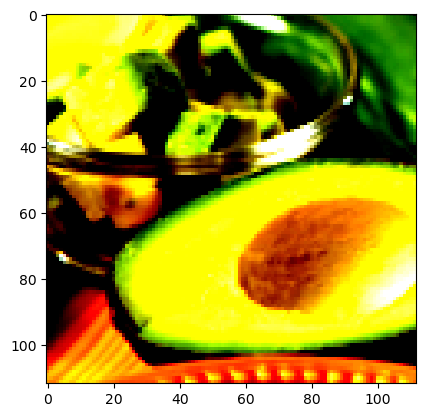

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


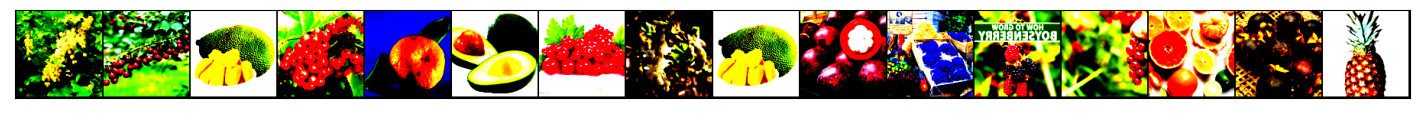

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*112*112
output_size = 55

In [16]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = num_classes
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 500)  # Adjusted based on input size
        self.fc2 = nn.Linear(500, self.num_classes)
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Adjusted for the modified input size
        
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        
        return x

In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 55])
out[0]: tensor([ 0.2299,  0.1714, -0.3324, -0.0000,  0.1719,  0.2587, -0.0000,  0.0514,
         0.0000, -0.0549, -0.0000, -0.0000, -0.0439,  0.0684,  0.0000, -0.0000,
        -0.3655, -0.0000,  0.3094,  0.0768, -0.0000, -0.0000, -0.0000,  0.0000,
         0.0237,  0.0000, -0.0000,  0.5698, -0.0936,  0.1978, -0.1489, -0.1289,
        -0.0000, -0.5138,  0.0000,  0.0000, -0.0000, -0.2129,  0.2268, -0.0000,
         0.0000,  0.1559, -0.5382,  0.0000,  0.1975,  0.0163, -0.0000, -0.0000,
         0.0058, -0.0000,  0.0000,  0.1392, -0.0000, -0.4089,  0.0000],
       grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=55, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.009428977966309, 'val_acc': 0.07112068682909012}]

In [23]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 20
opt_func = torch.optim.SGD
lr = 0.001

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.9749, val_loss: 3.9061, val_acc: 0.1595


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.8826, val_loss: 3.7817, val_acc: 0.2392


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7799, val_loss: 3.6396, val_acc: 0.2953


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.7131, val_loss: 3.5447, val_acc: 0.3125


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.6626, val_loss: 3.4686, val_acc: 0.3405


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.6040, val_loss: 3.4209, val_acc: 0.3728


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.5732, val_loss: 3.3701, val_acc: 0.3750


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.5304, val_loss: 3.3381, val_acc: 0.3772


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.5198, val_loss: 3.2955, val_acc: 0.3966


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.4733, val_loss: 3.2651, val_acc: 0.3966


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.4547, val_loss: 3.2350, val_acc: 0.4095


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.4064, val_loss: 3.1862, val_acc: 0.4009


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.3657, val_loss: 3.1560, val_acc: 0.4569


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.3610, val_loss: 3.1364, val_acc: 0.4203


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.3040, val_loss: 3.0934, val_acc: 0.4698


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.2820, val_loss: 3.0563, val_acc: 0.4591


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.2838, val_loss: 3.0424, val_acc: 0.4634


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.2462, val_loss: 3.0140, val_acc: 0.4569


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.2058, val_loss: 3.0065, val_acc: 0.4634


  0%|          | 0/485 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.1509, val_loss: 2.9759, val_acc: 0.4935


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

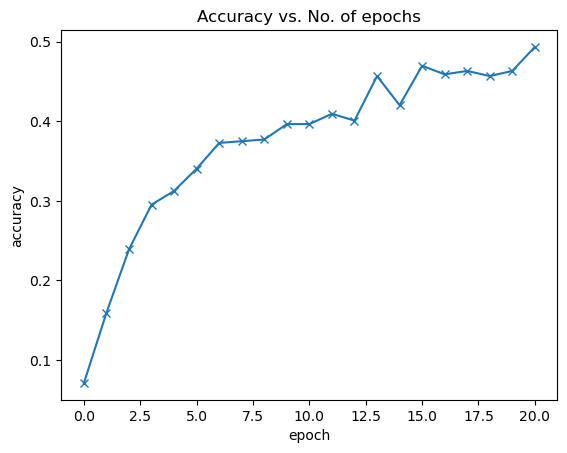

In [26]:
plot_accuracies(history)

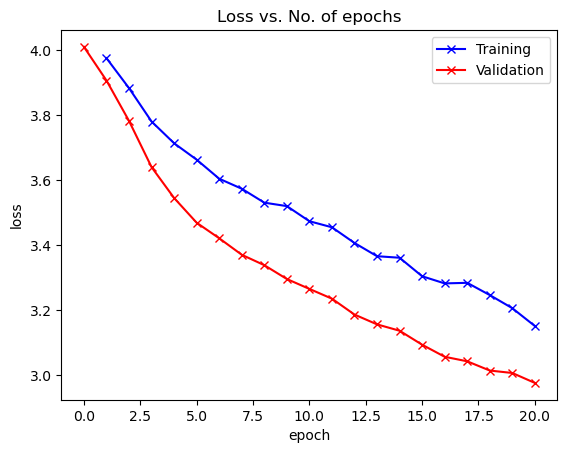

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 2.8913145065307617, 'val_acc': 0.5493420958518982}